In [14]:
import os
import argparse
import csv
import numpy
import matplotlib
from matplotlib import pyplot, image

In [15]:
def draw_display(dispsize, imagefile=None):
    """Returns a matplotlib.pyplot Figure and its axes, with a size of
    dispsize, a black background colour, and optionally with an image drawn
    onto it

    arguments

    dispsize		-	tuple or list indicating the size of the display,
                    e.g. (1024,768)

    keyword arguments

    imagefile		-	full path to an image file over which the heatmap
                    is to be laid, or None for no image; NOTE: the image
                    may be smaller than the display size, the function
                    assumes that the image was presented at the centre of
                    the display (default = None)

    returns
    fig, ax		-	matplotlib.pyplot Figure and its axes: field of zeros
                    with a size of dispsize, and an image drawn onto it
                    if an imagefile was passed
    """

    # construct screen (black background)
    screen = numpy.zeros((dispsize[1], dispsize[0], 3), dtype='float32')
    # if an image location has been passed, draw the image
    if imagefile != None:
        # check if the path to the image exists
        if not os.path.isfile(imagefile):
            raise Exception("ERROR in draw_display: imagefile not found at '%s'" % imagefile)
        # load image
        img = image.imread(imagefile)

        # width and height of the image
        w, h = len(img[0]), len(img)
        # x and y position of the image on the display
        x = dispsize[0] / 2 - w / 2
        y = dispsize[1] / 2 - h / 2
        # draw the image on the screen
        screen[y:y + h, x:x + w, :] += img
    # dots per inch
    dpi = 100.0
    # determine the figure size in inches
    figsize = (dispsize[0] / dpi, dispsize[1] / dpi)
    # create a figure
    fig = pyplot.figure(figsize=figsize, dpi=dpi, frameon=False)
    ax = pyplot.Axes(fig, [0, 0, 1, 1])
    ax.set_axis_off()
    fig.add_axes(ax)
    # plot display
    ax.axis([0, dispsize[0], 0, dispsize[1]])
    ax.imshow(screen)  # , origin='upper')

    return fig, ax

In [16]:
def gaussian(x, sx, y=None, sy=None):
    """Returns an array of numpy arrays (a matrix) containing values between
    1 and 0 in a 2D Gaussian distribution

    arguments
    x		-- width in pixels
    sx		-- width standard deviation

    keyword argments
    y		-- height in pixels (default = x)
    sy		-- height standard deviation (default = sx)
    """

    # square Gaussian if only x values are passed
    if y == None:
        y = x
    if sy == None:
        sy = sx
    # centers
    xo = x / 2
    yo = y / 2
    # matrix of zeros
    M = numpy.zeros([y, x], dtype=float)
    # gaussian matrix
    for i in range(x):
        for j in range(y):
            M[j, i] = numpy.exp(
                -1.0 * (((float(i) - xo) ** 2 / (2 * sx * sx)) + ((float(j) - yo) ** 2 / (2 * sy * sy))))

    return M

In [34]:
def draw_heatmap(gazepoints, dispsize, imagefile=None, alpha=0.5, savefilename=None, gaussianwh=200, gaussiansd=None):
    """Draws a heatmap of the provided fixations, optionally drawn over an
    image, and optionally allocating more weight to fixations with a higher
    duration.

    arguments

    gazepoints		-	a list of gazepoint tuples (x, y)
    
    dispsize		-	tuple or list indicating the size of the display,
                    e.g. (1024,768)

    keyword arguments

    imagefile		-	full path to an image file over which the heatmap
                    is to be laid, or None for no image; NOTE: the image
                    may be smaller than the display size, the function
                    assumes that the image was presented at the centre of
                    the display (default = None)
    alpha		-	float between 0 and 1, indicating the transparancy of
                    the heatmap, where 0 is completely transparant and 1
                    is completely untransparant (default = 0.5)
    savefilename	-	full path to the file in which the heatmap should be
                    saved, or None to not save the file (default = None)

    returns

    fig			-	a matplotlib.pyplot Figure instance, containing the
                    heatmap
    """

    # IMAGE
    fig, ax = draw_display(dispsize, imagefile=imagefile)

    # HEATMAP
    # Gaussian
    gwh = gaussianwh
    gsdwh = gwh / 6 if (gaussiansd is None) else gaussiansd
    gaus = gaussian(gwh, gsdwh)
    # matrix of zeroes
    strt = gwh / 2
    #heatmapsize = dispsize[1] + 2 * strt, dispsize[0] + 2 * strt
    heatmapsize = (int(dispsize[1] + 2 * strt), int(dispsize[0] + 2 * strt))
    heatmap = numpy.zeros(heatmapsize, dtype=float)
    # create heatmap
    for i in range(0, len(gazepoints)):
        # get x and y coordinates
        x = strt + gazepoints[i][0] - int(gwh / 2)
        y = strt + gazepoints[i][1] - int(gwh / 2)
        # correct Gaussian size if either coordinate falls outside of
        # display boundaries
        if (not 0 < x < dispsize[0]) or (not 0 < y < dispsize[1]):
            hadj = [0, gwh];
            vadj = [0, gwh]
            if 0 > x:
                hadj[0] = abs(x)
                x = 0
            elif dispsize[0] < x:
                hadj[1] = gwh - int(x - dispsize[0])
            if 0 > y:
                vadj[0] = abs(y)
                y = 0
            elif dispsize[1] < y:
                vadj[1] = gwh - int(y - dispsize[1])
            # add adjusted Gaussian to the current heatmap
            try:
                heatmap[y:y + vadj[1], x:x + hadj[1]] += gaus[vadj[0]:vadj[1], hadj[0]:hadj[1]] * gazepoints[i][2]
            except:
                # fixation was probably outside of display
                pass
        else:
            # add Gaussian to the current heatmap
            #heatmap[y:y + gwh, x:x + gwh] += gaus * gazepoints[i][2]
            heatmap[int(y):int(y) + int(gwh), int(x):int(x) + int(gwh)] += gaus * gazepoints[i][2]
    # resize heatmap
    #heatmap = heatmap[strt:dispsize[1] + strt, strt:dispsize[0] + strt]
    heatmap = heatmap[int(strt):int(dispsize[1]) + int(strt), int(strt):int(dispsize[0]) + int(strt)]

    # remove zeros
    lowbound = numpy.mean(heatmap[heatmap > 0])
    heatmap[heatmap < lowbound] = numpy.NaN
    # draw heatmap on top of image
    ax.imshow(heatmap, cmap='jet', alpha=alpha)

    # FINISH PLOT
    # invert the y axis, as (0,0) is top left on a display
    ax.invert_yaxis()
    # save the figure if a file name was provided
    if savefilename != None:
        fig.savefig(savefilename)

    return fig

In [35]:
parser = argparse.ArgumentParser(description='Parameters required for processing.')

#required args
parser.add_argument('input-path', type=str, help='path to the csv input')
parser.add_argument('display-width', type=int, help='an integer representing the display width')
parser.add_argument('display-height', type=int, help='an integer representing the display height')

#optional args
parser.add_argument('-a', '--alpha', type=float, default='0.5', required=False, help='alpha for the gaze overlay')
parser.add_argument('-o',  '--output-name', type=str, required=False, help='name for the output file')
parser.add_argument('-b',  '--background-image', type=str, default=None, required=False, help='path to the background image')

#advanced optional args
parser.add_argument('-n', '--n-gaussian-matrix', type=int, default='200', required=False, help='width and height of gaussian matrix')
parser.add_argument('-sd',  '--standard-deviation', type=float, default=None ,required=False, help='standard deviation of gaussian distribution')


_StoreAction(option_strings=['-sd', '--standard-deviation'], dest='standard_deviation', nargs=None, const=None, default=None, type=<class 'float'>, choices=None, required=False, help='standard deviation of gaussian distribution', metavar=None)

In [36]:


input_path = 'heatmap_data.csv'
display_width = 1920
display_height = 1080
alpha = 0.5
output_name = 'output_heatmap'
background_image = None #Poner ruta a la imagen de background si quiero una
ngaussian = 200
sd = None

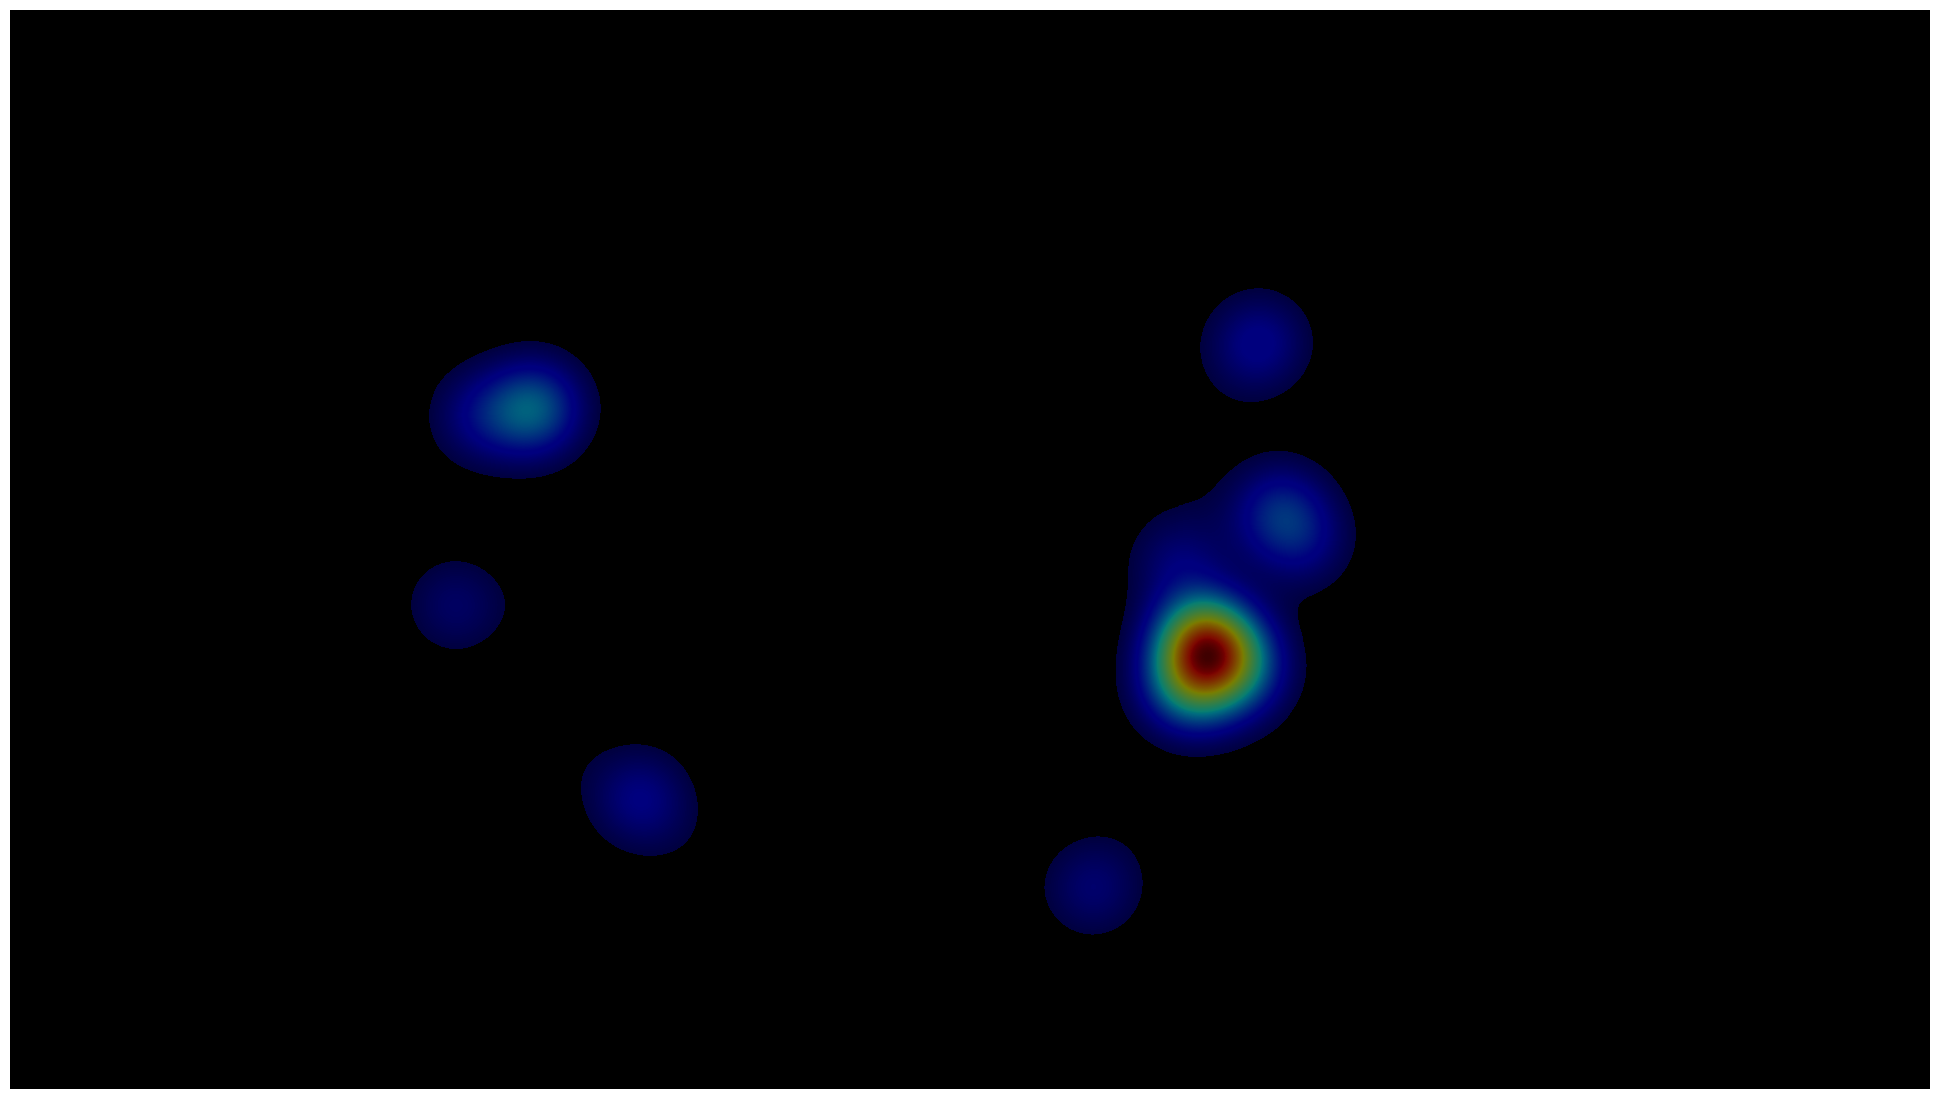

In [37]:
with open(input_path) as f:
    reader = csv.reader(f)
    raw = list(reader)
    
    gaza_data = []
    if len(raw[0]) == 2:
        gaze_data = list(map(lambda q: (int(q[0]), int(q[1]), 1), raw))
    else:
        gaze_data =  list(map(lambda q: (int(q[0]), int(q[1]), int(q[2])), raw))

    draw_heatmap(gaze_data, (display_width, display_height), alpha=alpha, savefilename=output_name, imagefile=background_image, gaussianwh=ngaussian, gaussiansd=sd)